# Project 2 - Linear Classification and Nearest Neighbor Classification

# Mandana Samiei
Student ID: 260779555

# Q1, Q2 and Q3

In [48]:
import numpy as np 
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt
import csv
import math
from numpy.linalg import inv
%matplotlib inline  

def load_mean(file_name):
    my_data = genfromtxt(file_name, delimiter=',')
    mean = my_data[:20]
    return mean
def load_cov(file_name):
    my_data = genfromtxt(file_name, delimiter = ',')
    cov = my_data[:,:20]
    return cov
def load_data(file_name):
    my_data = genfromtxt(file_name, delimiter = ',')
    return my_data

# Data generation and manipulation

In [49]:
def generate_data(m0,m1,cov,num=2000):
    x0 = np.random.multivariate_normal(m0,cov,num) # 2000*20 neg
    x1 = np.random.multivariate_normal(m1,cov,num) # pos
    return x0,x1  
def label_data(x0,x1): # add -1 as a label for negative classes and +1 as label for poseive classes 
    y0 = np.zeros((2000,1))
    y1 = np.ones((2000,1))
    d0 = np.concatenate((x0,(y0-1)),axis=1) #2000*21
    d1 = np.concatenate((x1,y1),axis=1)
    return d0,d1
def divide_data(d0,d1):
    rand_num0 =  np.random.permutation(d0.shape[0])
    test_0 = d0[rand_num0[:600]]
    train_0 = d0[rand_num0[600:]]
    rand_num1 =  np.random.permutation(d1.shape[0])
    test_1 = d1[rand_num1[:600]]
    train_1 = d1[rand_num1[600:]]  
    test_data = np.concatenate((test_0,test_1),axis=0)
    train_data = np.concatenate((train_0,train_1),axis=0) 
    return test_data, train_data
def shuffle_data(x):
    np.random.shuffle(x)
    return x
def save_data(train, test):
    np.savetxt("DS1_train.csv", train, fmt='%15s', delimiter=',')    
    np.savetxt("DS1.csv", test, fmt='%15s', delimiter=',')    

# Learn LDA Parameters : Mu1, Mu2, Covariance, p(C1), p(C2)

Using the maximum likelihood of data points(x,t),
we often maximize log of likelihood function instead of likelihood function 

In [50]:
def LDA_parameters(x_c1, x_c2):
    N1 = x_c1.shape[0] # Number of Negative examples
    N2 = x_c2.shape[0] # Number of Posetive examples
    total_samples = N1 + N2
    # Learn P(c1) and P(c2)
    p_c1  = float(N1)/total_samples#fraction of points in c1 over total number of points 
    p_c2  = float(N2)/total_samples#fraction of points in c2 over total number of points
    # Learn Mu1 and Mu2
    Mu1 = x_c1[:,:].mean(axis=0)
    Mu2 = x_c2[:,:].mean(axis=0)
    # learn covariance
    S1 = np.dot((x_c1[:,:] - Mu1).T,(x_c1[:,:] - Mu1))/N1
    S2 = np.dot(((x_c2[:,:] - Mu2).T),(x_c2[:,:] - Mu2))/N2
    cov = p_c1*S1 + p_c2*S2
    return Mu1, Mu2, cov, p_c1, p_c2

def LDA_model(mu1, mu2, cov, p_c1, p_c2):
    b = inv(cov)
    w = np.dot(b,(mu1-mu2))
    w0 = -(np.dot((mu1.T),np.dot(b,mu1)))/2. + (np.dot((mu2.T),np.dot(b,mu2)))/2. + np.log(p_c1/float(p_c2))
    return w,w0
    
def LDA_prediction(w,w0,x):
    a = np.dot(x,(w.T)) + w0 
    y = 1./ (1. + np.exp(-a)) # y = sigmoid(a)
    for i in range(y.shape[0]):
        if y[i] > 0.5:
            y[i] = -1.0
        else: 
            y[i] = 1.0
    return y

# K-Nearest_Neighbour Algorithm 

In [51]:
def KNN(train_set, test_set, k):
    labels = np.zeros(test_set.shape[0])
    for i in range(test_set.shape[0]):
        distances = np.linalg.norm(train_set[:,:20] - test_set[i,:20][None,:],axis=1)
        neighbours = distances.argsort()[:k]
        if train_set[neighbours,20].sum() > 0.0:
            labels[i] = +1
        else:
            labels[i] = -1
    return labels

# Evaluation Metrics

In [31]:
def get_accuracy(test_set, prediction):
    correct = 0
    for i in range(test_set.shape[0]):
        if (test_set[i] == prediction[i]):
            correct += 1;
    accuracy = (correct / float(test_set.shape[0]))* 100.0
    return accuracy
def get_precision(test_set, prediction):
    TP,_,FP,_ = get_confusion_mat(test_set, prediction)
    precision = float(TP) / (TP+FP)
    return precision* 100.0
def get_recall(test_set, prediction):
    TP,_,_,FN = get_confusion_mat(test_set, prediction)
    recall = float(TP) / (TP+FN)
    return recall* 100.0
def get_Fmeasure(pr, rc):
    return 2*(pr*rc)/float(pr+rc)
def get_confusion_mat(test_set, prediction):
    TP, TN, FN, FP = 0, 0, 0, 0
    for i in range(test_set.shape[0]):
        if test_set[i] == prediction[i] and test_set[i] == 1.0: # True Posetive
            TP +=1
        elif test_set[i] == prediction[i] and test_set[i] == -1.0: # True Negative
            TN +=1 
        elif test_set[i] != prediction[i] and test_set[i] == 1.0: # False Negative
            FN +=1
        elif test_set[i] != prediction[i] and test_set[i] == -1.0: # False Posetive
            FP +=1
    return TP, TN, FP, FN

# Visualization

In [44]:
def visualize_metrics(train_data, test_data):
    accuracy_, precision_, recall_, f1_measure_ = [], [], [], []
    conf_mat = [[],[]]
    for k in range(1,200,2):
        test_labels_predicted = KNN(train_data, test_data, k)
        accuracy = get_accuracy(test_data[:,20],test_labels_predicted)
        precision = get_precision(test_data[:,20],test_labels_predicted)
        recall = get_recall(test_data[:,20],test_labels_predicted)
        f1_measure = get_Fmeasure(precision, recall)
        TP, TN, FP, FN = get_confusion_mat(test_data[:,20], test_labels_predicted)
        conf_mat[0] = [TP, FP]
        conf_mat[1] = [FN, TN]
        print "\n__ K = {}  ___ Confusion matrix = {}" .format(k, conf_mat)
        print "\nAccuracy: {}%" .format(accuracy)
        print "Precision: {}%" .format(precision)
        print "Recall: {}%" .format(recall)
        print "F1_measure: {}%" .format(f1_measure)
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_measure_.append(f1_measure)
    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.plot(range(1,200,2), accuracy_, c='#FFA500',label = "accuracy")
    ax.plot(range(1,200,2), precision_, c='b',label = "precision")
    ax.plot(range(1,200,2), recall_, c='c',label = "recall")
    ax.plot(range(1,200,2), f1_measure_, c='r',label = "f1_measure")
    plt.ylabel('Metrics%')
    plt.xlabel('K')
    plt.legend(loc='best', shadow=True)
    plt.title('Metrics Evaluation using different values of K')
    plt.show()
    max_acc, max_pre, max_rec, max_f1 = max(accuracy_), max(precision_), max(recall_), max(f1_measure_)
    print "\nMaximum Accuracy: {}  with k = {}"  .format(max_acc, accuracy_.index(max_acc)*2+1)
    print "\nMaximum Precision: {}  with k = {}"  .format(max_pre, precision_.index(max_pre)*2+1)
    print "\nMaximum Recall: {}  with k = {}"  .format(max_rec, recall_.index(max_rec)*2+1)
    print "\nMaximum F1 Measure: {}  with k = {}"  .format(max_f1, f1_measure_.index(max_f1)*2+1)
def visualize_error_rate(train_data, test_data):
    test_error_rates = []
    train_error_rates = []
    for k in range(1,200,2):
        test_labels_predicted = KNN(train_data, test_data, k)
        test_error_rates.append(float((test_labels_predicted != test_data[:,20]).sum()) / test_labels_predicted.shape[0])
        train_labels_predicted = KNN(train_data, train_data, k)
        train_error_rates.append(float((train_labels_predicted != train_data[:,20]).sum()) / train_labels_predicted.shape[0])
    fig, ax = plt.subplots(1, figsize=(10,6))    
    ax.plot(range(1,200,2), train_error_rates, c='r',label = "Train Error Rate")
    ax.plot(range(1,200,2), test_error_rates, c='b',label = "test Error Rate")
    plt.ylabel('Error Rates')
    plt.xlabel('K')
    plt.legend(loc='best', shadow=True)
    plt.title('Train and Test error rate over different values of K')
    plt.show()
    min_error = min(test_error_rates)
    print "\nMinimum Test Error rate: {}  with k = {}\n"  .format(min_error, test_error_rates.index(min_error)*2+1)

# Main Function 

____________________________________Learnt parameters of LDA______________________________

Mu0=
[ 1.27746695  1.2578455   1.28619515  1.29220047  1.24561031  1.27967428
  1.2689333   1.32955749  1.25790099  1.28314412  1.25072978  1.27652658
  1.26173218  1.26612629  1.25685482  1.30209322  1.26055791  1.28992743
  1.23896141  1.23960763]
Mu1=
[ 2.01923032  2.04072949  2.03241233  2.00645701  2.02743077  2.03258773
  2.05620192  2.02332699  2.0082138   1.98594544  1.9750355   2.06058526
  2.03775182  1.99228914  2.04392202  2.00972211  2.03019466  2.03099777
  2.05935527  2.00093327]
Covariance=
[[ 7.86771572  5.44986443  6.07583871  5.07032478  5.67375101  6.06138612
   4.62105968  5.45575764  4.93504503  5.12154289  3.85854875  5.19721014
   6.91757219  5.96552242  5.97744081  5.95400779  5.78691927  5.68078496
   5.56103359  5.77105454]
 [ 5.44986443  6.69485372  5.27605633  4.24108843  5.35153445  5.4599997
   4.32753567  3.92813278  4.12759425  4.88847293  3.26121456  4.59523961



__ K = 17  ___ Confusion matrix = [[339, 289], [261, 311]]

Accuracy: 54.1666666667%
Precision: 53.9808917197%
Recall: 56.5%
F1_measure: 55.2117263844%

__ K = 19  ___ Confusion matrix = [[337, 283], [263, 317]]

Accuracy: 54.5%
Precision: 54.3548387097%
Recall: 56.1666666667%
F1_measure: 55.2459016393%

__ K = 21  ___ Confusion matrix = [[343, 284], [257, 316]]

Accuracy: 54.9166666667%
Precision: 54.7049441786%
Recall: 57.1666666667%
F1_measure: 55.9087204564%

__ K = 23  ___ Confusion matrix = [[342, 285], [258, 315]]

Accuracy: 54.75%
Precision: 54.5454545455%
Recall: 57.0%
F1_measure: 55.7457212714%

__ K = 25  ___ Confusion matrix = [[343, 276], [257, 324]]

Accuracy: 55.5833333333%
Precision: 55.4119547658%
Recall: 57.1666666667%
F1_measure: 56.275635767%

__ K = 27  ___ Confusion matrix = [[357, 282], [243, 318]]

Accuracy: 56.25%
Precision: 55.8685446009%
Recall: 59.5%
F1_measure: 57.6271186441%

__ K = 29  ___ Confusion matrix = [[356, 280], [244, 320]]

Accuracy: 56.3333333


__ K = 123  ___ Confusion matrix = [[361, 280], [239, 320]]

Accuracy: 56.75%
Precision: 56.3182527301%
Recall: 60.1666666667%
F1_measure: 58.1788879936%

__ K = 125  ___ Confusion matrix = [[364, 285], [236, 315]]

Accuracy: 56.5833333333%
Precision: 56.0862865948%
Recall: 60.6666666667%
F1_measure: 58.2866293034%

__ K = 127  ___ Confusion matrix = [[361, 281], [239, 319]]

Accuracy: 56.6666666667%
Precision: 56.230529595%
Recall: 60.1666666667%
F1_measure: 58.1320450886%

__ K = 129  ___ Confusion matrix = [[358, 283], [242, 317]]

Accuracy: 56.25%
Precision: 55.8502340094%
Recall: 59.6666666667%
F1_measure: 57.6954069299%

__ K = 131  ___ Confusion matrix = [[360, 281], [240, 319]]

Accuracy: 56.5833333333%
Precision: 56.1622464899%
Recall: 60.0%
F1_measure: 58.017727639%

__ K = 133  ___ Confusion matrix = [[361, 282], [239, 318]]

Accuracy: 56.5833333333%
Precision: 56.1430793157%
Recall: 60.1666666667%
F1_measure: 58.0852775543%

__ K = 135  ___ Confusion matrix = [[362, 286], 

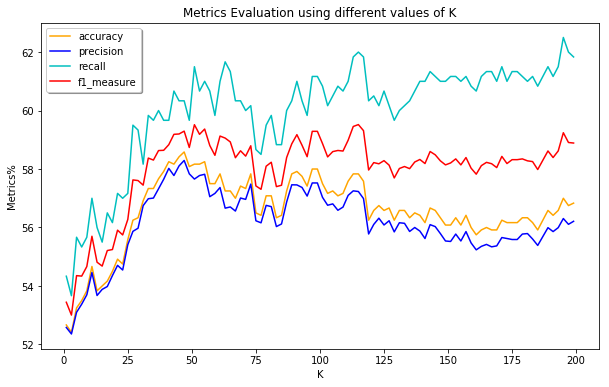


Maximum Accuracy: 58.5833333333  with k = 47

Maximum Precision: 58.2930756844  with k = 47

Maximum Recall: 62.5  with k = 195

Maximum F1 Measure: 59.52  with k = 115


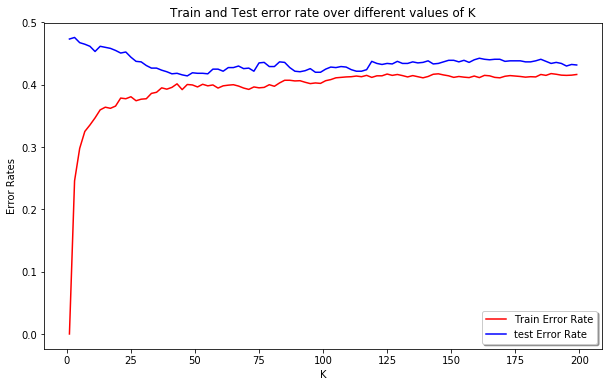


Minimum Test Error rate: 0.414166666667  with k = 47



In [46]:
m0 = load_mean("hwk2_datasets_corrected/DS1_m_0.txt") # m1 = 1.3
m1 = load_mean("hwk2_datasets_corrected/DS1_m_1.txt") # m2 = 2
cov = load_cov("hwk2_datasets_corrected/DS1_Cov.txt")

x_c1,x_c2 = generate_data(m0,m1,cov)
d0, d1 = label_data(x_c1,x_c2)
test_data, train_data = divide_data(d0,d1) #division
save_data(train_data,test_data)           # Save train and test data
test_data  = load_data("DS1.csv")   # load test data
train_data = load_data("DS1_train.csv") # load train data
train_data = shuffle_data(train_data)  # shuffle train data
test_data = shuffle_data(test_data)   # shuffle test data

#_________________________________________Learn LDA Parameters___________________________________
mu0, mu1, cov_, p_c1, p_c2 = LDA_parameters(x_c1,x_c2)
w, w0 = LDA_model(mu0, mu1, cov_, p_c1, p_c2)
print "____________________________________Learnt parameters of LDA______________________________"

print "\nMu0=\n{}\nMu1=\n{}\nCovariance=\n{}\n\nP_C1={}\nP_C2={}\n" .format(mu0,mu1,cov_,p_c1,p_c2)

print "_______________________________ calculating w and w0_____________________________________\n"
print "W: \n{}" .format(w)
print "W0: \n{}" .format(w0)

print "\n________________________LDA prediction for known data points____________________________\n"

c1_labels = LDA_prediction(w,w0,x_c1) 
print "Sum of class_1 labels(Negative Class): \n{}" .format(c1_labels.sum())
c2_labels = LDA_prediction(w,w0,x_c2)
print "Sum of class_2 labels(Positive Class): \n{}" .format(c2_labels.sum())

print "___________________________________ classification__________________________________________\n"

print "_____________________________ Train Set Evaluation (LDA) ___________________________________"

train_predicted_y = LDA_prediction(w,w0,train_data[:,:20])
accuracy = get_accuracy(train_data[:,20],train_predicted_y)
print "\nAccuracy of train in LDA: \n{}%" .format(accuracy)

print "_______________________________________Test Set Evaluation(LDA)______________________________"
test_y = LDA_prediction(w,w0,test_data[:,:20])
accuracy = get_accuracy(test_data[:,20],test_y)
print "\nAccuracy: {}%" .format(accuracy)
precision = get_precision(test_data[:,20],test_y)
print "\nPrecision: {}%" .format(precision)
recall = get_recall(test_data[:,20],test_y)
print "\nRecall: {}%" .format(recall)
f_measure = get_Fmeasure(precision, recall)
print "\nF-measure: {}%" .format(f_measure)

print "________________________________Test Set Evaluation KNN with K = 5____________________________"
test_labels_predicted = KNN(train_data, test_data, 5)
accuracy = get_accuracy(test_data[:,20],test_labels_predicted)
print "\nAccuracy: {}%" .format(accuracy)
precision = get_precision(test_data[:,20],test_labels_predicted)
print "\nPrecision: {}%" .format(precision)
recall = get_recall(test_data[:,20],test_labels_predicted)
print "\nRecall: {}%" .format(recall)
f_measure = get_Fmeasure(precision, recall)
print "\nF-measure: {}%" .format(f_measure)


print "\n________________________ classification Evaluation *** KNN *** with different K _____________"
print "\n________________________________________Visualization________________________________________\n"
visualize_metrics(train_data, test_data)
visualize_error_rate(train_data, test_data)
